In [ ]:
import random

import dac
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor
from typing import List

In [ ]:
# We've hard coded the number of codes we will output to the size of the files
# given initially. Change this if you have different length files.

CODES_LEN = 431
ORIGINAL_LENGTH = 220500
SAMPLE_RATE = 44100
VOCAB_SIZE = 1024

# Set to value of data_dir in the config file.
DATA_PATH = "testdata/experiment2/data/"

In [57]:
def ramp(low: int, high: int) -> List[int]:
    current = low
    codebook = [current]

    while len(codebook) < CODES_LEN:
        current += 1
        if current >= high:
            current = low
        codebook.append(current)

    return codebook


def banded_noise(low: int, high: int) -> List[int]:
    codebook = []

    while len(codebook) < CODES_LEN:
        codebook.append(random.randint(low, high))

    return codebook


def make_dac_file(gen_fn, n_codebooks: int, filename: str, **k):
    # Number of codebooks must be a power of 2
    assert (n_codebooks & (n_codebooks - 1) == 0) and n_codebooks != 0

    codebooks = []
    for _ in range(n_codebooks):
        codebooks.append([])

    # Call the generator function with the given arguments to get values
    # for the first codebook
    codebooks[0] = gen_fn(**k)

    # Set other codebooks to noise
    for i in range(1, n_codebooks):
        for _ in range(CODES_LEN):
            codebooks[i].append(random.randint(0, VOCAB_SIZE))

    dac_file = dac.DACFile(
        codes=tensor([codebooks]),
        chunk_length=CODES_LEN,
        original_length=ORIGINAL_LENGTH,
        input_db=tensor([-30.0]),
        channels=1,
        sample_rate=SAMPLE_RATE,
        padding=True,
        dac_version="1.0.0",
    )

    dac_file.save(filename)

Example usage. Let's do an experiment with 4 files that ramp in different bands, and let's use 2 codebooks. The first codebook will have the ramps, the rest will be set to noise.

In [58]:
n_codebooks = 2

make_dac_file(ramp, n_codebooks, DATA_PATH + "one_hundred", low=0, high=100)
make_dac_file(ramp, n_codebooks, DATA_PATH + "two_hundred", low=100, high=200)
make_dac_file(ramp, n_codebooks, DATA_PATH + "three_hundred", low=200, high=300)
make_dac_file(ramp, n_codebooks, DATA_PATH + "four_hundred", low=300, high=400)

Let's simulate what we expect to see when we run the conditioning experiment, i.e. switching between classes at fixed intervals. Because the code we were given seems to sort the file names alphabetically, the sequence of codes we should see are `four_hundred`, `one_hundred`, `three_hundred`, `two_hundred`. We're plotting the code values we expect to see in the first codebook.

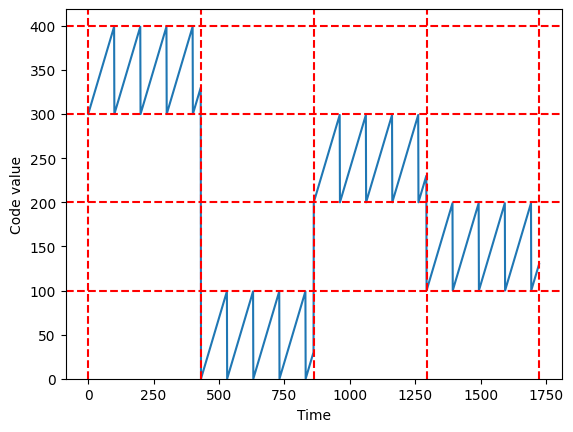

In [ ]:
ys = []

for params in [(300, 400), (0, 100), (200, 300), (100, 200)]:
    low = params[0]
    high = params[1]
    ys += ramp(low, high)

plt.plot(ys)

for y in [100, 200, 300, 400]:
    plt.axhline(y=y, color="r", linestyle="--")
for x in np.linspace(0, len(ys), 5):
    plt.axvline(x=x, color="r", linestyle="--")
plt.ylim(0)
plt.xlabel("Time")
plt.ylabel("Code value")

plt.show()


Now set the number of codebooks in the parameters file and train the network. Then run inference to generate a DAC file which we inspect. The goal is to see if we get these sharp transitions between classes, and to see if we stay within the code boundaries of a class.

In [48]:
def plot_result(out_dac_filepath):
    out_dac_file = dac.DACFile.load(out_dac_filepath)
    out_codes = out_dac_file.codes.tolist()[0][0] # First codebook

    plt.plot(out_codes)
    for y in [100, 200, 300, 400]:
        plt.axhline(y=y, color="r", linestyle="--")
    for x in np.linspace(0, len(out_codes), 5):
        plt.axvline(x=x, color="r", linestyle="--")
    plt.ylim(0)
    plt.xlabel("Time")
    plt.ylabel("Code value")
    plt.show()    

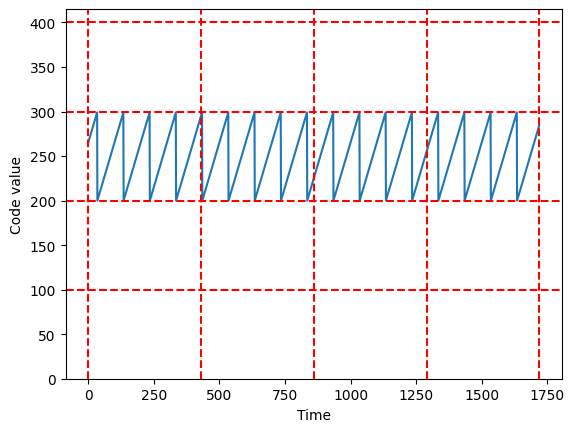

In [49]:
plot_result("runs/experiment_2/dacs/conditioning_chkpt_0300_steps_1720.topn_0020.dac")

We see that the output it 'stuck'. In this case we also forced the initial random codes that are generated when starting the inference to be between 200 and 300 which is why we see the the generated output starts there. Clearly conditioning has no effect here - it's not 'strong' enough to override the very regular pattern it's seen. Let's try with 8 codebooks now, keeping the same initially generated random values to be between 200 and 300. We populate the higher codebooks with noise, hoping that the network has a tougher time seeing patterns that it gets locked to.

Again, the flow is create the DAC files, change the config codebook size, train, run inference, plot.

In [51]:
n_codebooks = 8

make_dac_file(ramp, n_codebooks, DATA_PATH + "one_hundred", low=0, high=100)
make_dac_file(ramp, n_codebooks, DATA_PATH + "two_hundred", low=100, high=200)
make_dac_file(ramp, n_codebooks, DATA_PATH + "three_hundred", low=200, high=300)
make_dac_file(ramp, n_codebooks, DATA_PATH + "four_hundred", low=300, high=400)

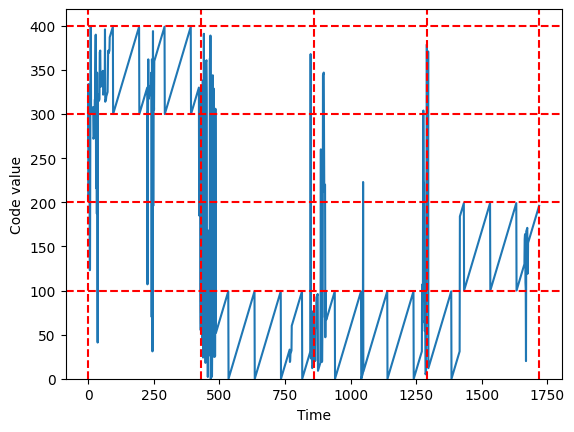

In [52]:
plot_result("runs/experiment_2/dacs/conditioning_chkpt_0300_steps_1720.topn_0020.dac")

It's a bit closer to our initial expectation, but it still has some trouble snapping to the right classes. When transitions do happen, they're roughly where we expect them. This led us to conclude that 'stickiness' occurs with training data that has very regular patterns.

This led us to try the same experiment but with banded noise. Noise should be a lot harder to predict - the only thing that's regular about the noise we'll create is that it lies in bands so that we can tell when we're going from one class to another. Becuase it's hard to predict, we would expect the conditioning to have a stronger effect because it's not as inclined to keep within the same class because it's not in a strong pattern.

Here's the output we'd expect.

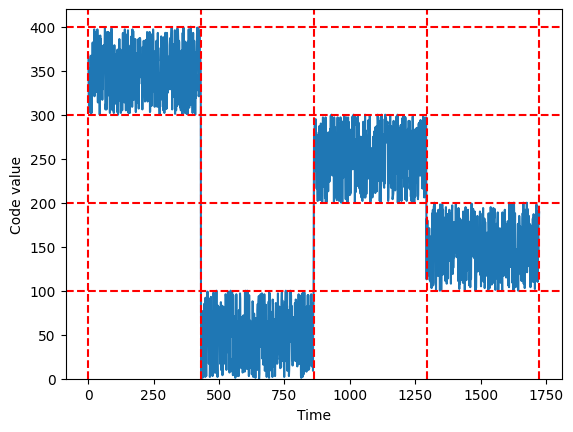

In [53]:
ys = []

for params in [(300, 400), (0, 100), (200, 300), (100, 200)]:
    low = params[0]
    high = params[1]
    ys += banded_noise(low, high)

plt.plot(ys)

for y in [100, 200, 300, 400]:
    plt.axhline(y=y, color="r", linestyle="--")
for x in np.linspace(0, len(ys), 5):
    plt.axvline(x=x, color="r", linestyle="--")
plt.ylim(0)
plt.xlabel("Time")
plt.ylabel("Code value")

plt.show()


Let's run another experiment, this time going straight to 8 codebooks. The idea of experimenting with noise in more codebooks is that with more noise, the pattern should be more unpredictable so we should see less stickiness. Note that we've changed our generator function to `banded_noise` now.

In [54]:
n_codebooks = 8

make_dac_file(banded_noise, n_codebooks, DATA_PATH + "one_hundred", low=0, high=100)
make_dac_file(banded_noise, n_codebooks, DATA_PATH + "two_hundred", low=100, high=200)
make_dac_file(banded_noise, n_codebooks, DATA_PATH + "three_hundred", low=200, high=300)
make_dac_file(banded_noise, n_codebooks, DATA_PATH + "four_hundred", low=300, high=400)

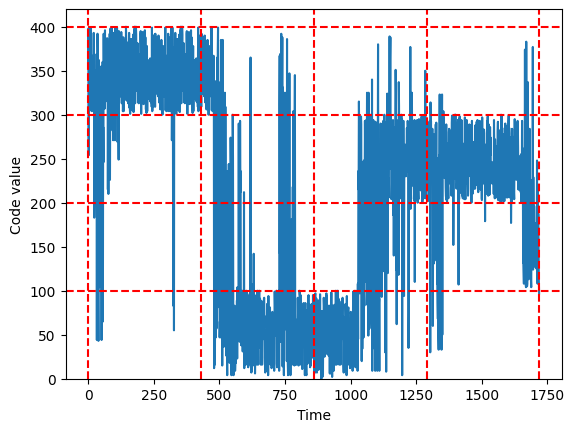

In [55]:
plot_result("runs/experiment_2/dacs/conditioning_chkpt_0300_steps_1720.topn_0020.dac")

We're slightly better at snapping to the correct classes, but the transitions aren't exactly where we want them and we see that we often sticking for too long. The last class is poorly represented. This suggests that the network has picked up on the banding of the noise, and likes to stick to those bands, but not as strongly as when the input is more regular.

These experiments demonstrate the problem of stickiness to one class when there's some regularity in the codes seen in the audio despite changing the conditioning to output other classes. In extreme cases we see that the initial randomly generated codes will influence which class the network will stick to. We show that introducing randomness helps un-stick the network, suggesting in cases where the conditioning vector does work well, it's due to the more random nature of the distribution of codes in the input audio.